In [1]:
import os
import cPickle as pickle
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from keras.models import Sequential
from keras.layers import Dense


nn_layer1 = 100 
nn_layer2 = 50
model = Sequential()
model.add(Dense(nn_layer1, input_shape=(1,), init='normal', activation='relu'))
model.add(Dense(nn_layer2, init='normal', activation='relu'))
model.add(Dense(1, init='normal'))

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

Using Theano backend.


In [2]:
l1 = model.layers[0]

In [23]:
def init_model(nn_layer1=100, nn_layer2=50):
    # construct regression model
    model = Sequential()
    model.add(Dense(nn_layer1, input_shape=(1,), init='normal', activation='relu'))
    model.add(Dense(nn_layer2, init='normal', activation='relu'))
    model.add(Dense(1, init='normal'))

    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


# file and directory information
data_dir = "./data/"
out_dir = "./results/"
f_prefix = "synthetic_time_series_generator_RBFNetwork_kernel_gaussian_scheme"
f_scheme = "switching"

# create files
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
loadfile = os.path.join(data_dir, f_prefix + "_" + f_scheme + ".pkl")

data_dict = pickle.load(open(loadfile, "rb"))
orig_obs = data_dict['orig_func_obs']
orig_data = data_dict['orig_func_data']
orig_plot_vals = data_dict['orig_func_plot_vals']

# get shapes of arrays
data_dim = orig_data.shape[1]
obs_dim = orig_obs.shape[1]
plot_dim = orig_plot_vals.shape[1]
nsamp = orig_data.shape[0]
nsteps = orig_data.shape[2]
nplot = orig_plot_vals.shape[0]
data_start = 0
data_end = 2*np.pi
plot_data = np.linspace(data_start, data_end, nplot)
plot_data_in = np.reshape(plot_data, (nplot, 1))
pred_plot_vals = np.zeros(orig_plot_vals.shape)

nlayer1 = 100
nlayer2 = 50
input_weight_vals = np.zeros((nlayer1, nsteps))
mid_weight_vals = np.zeros((nlayer1, nlayer2, nsteps))
output_weight_vals = np.zeros((nlayer2, nsteps))

nframes = nsteps
for i in xrange(1):
    print "Step ", i
    curr_model = init_model(nn_layer1=nlayer1, nn_layer2=nlayer2)
    curr_model.fit(orig_data[:, :, i], np.squeeze(orig_obs[:, :, i]), batch_size=200, nb_epoch=1000, verbose=0)
    pred_plot_vals[:, :, i] = curr_model.predict(plot_data_in)
    input_weight_vals[:, i] = curr_model.get_weights()[0].reshape((nlayer1,))
    mid_weight_vals[:, :, i] = curr_model.get_weights()[2]  # weights of penultimate layer
    output_weight_vals[:, i] = curr_model.get_weights()[3]  # weights of penultimate layer

Step  0


In [24]:
print orig_data[:, :, i].shape, orig_obs[:, :, i].shape

(500, 1) (500, 1)


In [25]:
l1 = curr_model.layers[0]

In [32]:
curr_model.get_weights()[3]

array([-0.00587883, -0.0631838 , -0.03491333, -0.00597783, -0.00939155,
       -0.05126859,  0.16648857,  0.25044489, -0.00599564, -0.15869416,
       -0.01211807, -0.01122063, -0.00801027, -0.06922191, -0.00903771,
       -0.01172417, -0.05956441, -0.05367146,  0.06304613,  0.1557167 ,
       -0.07326406, -0.00596087, -0.02545241, -0.06467783, -0.06799357,
       -0.00600539, -0.0191419 ,  0.05954603, -0.04201824, -0.0431719 ,
       -0.05664695, -0.07214134, -0.00597259, -0.00796453,  0.09543817,
       -0.06068489, -0.00599022, -0.05326713, -0.05119163, -0.0131403 ,
        0.18062231, -0.08154652, -0.01081883,  0.165672  , -0.04682567,
        0.17590453, -0.16074115, -0.0112678 , -0.00600264, -0.00600544], dtype=float32)

In [50]:
curr_data = orig_data[:, :, 0]
curr_obs = np.squeeze(orig_obs[:, :, 0])

# go through each layer, mapping the data and see if you get the same result
l0 = curr_model.layers[0]
l1 = curr_model.layers[1]
l2 = curr_model.layers[2]

In [60]:
def map_data(model, data):
    """
    Given a DNN keras model with dense layers all the way through, map the data until
    the penultimate layer, before the final summation.

    :param model: keras DNN model with Dense layers.
    :param data: data of shape (N, D).
    :return:
    """
    mapped_data = data
    nlayers = len(model.layers)
    for i in xrange(nlayers-1):
        curr_layer = model.layers[i]
        mapped_data = curr_layer.activation(np.dot(mapped_data, curr_layer.get_weights()[0])
                                            + curr_layer.get_weights()[1])
    return mapped_data

In [103]:
mapped_data = map_data(curr_model, curr_data)
mapped_preds = np.dot(mapped_data, model.layers[-1].get_weights()[0])
curr_preds = curr_model.predict(curr_data)

In [104]:
print mapped_preds.shape, curr_preds.shape

(500, 1) (500, 1)


In [105]:
print mapped_preds[0:10], "\n",  curr_preds[0:10]

[[-0.1306423 ]
 [-0.13089383]
 [-0.13114536]
 [-0.1313969 ]
 [-0.13164843]
 [-0.13189996]
 [-0.1321515 ]
 [-0.13240303]
 [-0.13265456]
 [-0.1329061 ]] 
[[-0.51187468]
 [-0.50238252]
 [-0.49289119]
 [-0.48339936]
 [-0.47390747]
 [-0.46441594]
 [-0.45492411]
 [-0.44543222]
 [-0.4359405 ]
 [-0.42644879]]


In [68]:
import theano as T

In [106]:
get_activations = T.function([curr_model.layers[0].input], curr_model.layers[1].output)

In [107]:
mapped_data2 = get_activations(curr_data.astype(np.float32))

In [108]:
mapped_preds2 = np.dot(mapped_data2, model.layers[-1].get_weights()[0]) + model.layers[-1].get_weights()[1]
curr_preds = curr_model.predict(curr_data)

/usr/lib/python2.7/site-packages/numpy/linalg/linalg.py:2168: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  (ord in ('f', 'fro') and ndim == 2) or


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [100]:
print mapped_preds2.shape, curr_preds.shape

(500, 1) (500, 1)


In [110]:
print np.mean(curr_preds), "\n", np.mean(mapped_preds2)

-0.125998 
-0.0651453


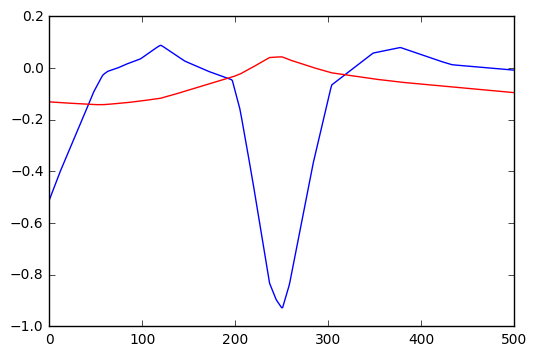

In [111]:
import matplotlib.pyplot as plt

sorted_preds = np.sort(curr_preds)
sorted_m_preds2 = np.sort(mapped_preds2)

plt.plot(curr_preds, 'b-')
plt.plot(mapped_preds, 'r-')
plt.show()

In [112]:
mapped_data_sorted = get_activations(np.sort(curr_data.astype(np.float32)))

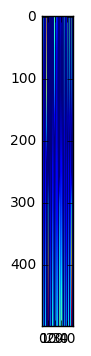

In [115]:
plt.imshow(mapped_data_sorted)
plt.show()

In [119]:
last_layer = curr_model.layers[2]

In [132]:
curr_model.layers[0].input_shape[1]

1

In [137]:
print [i for i in xrange(1, 2)]

[1]
